ECE1512 Project A Task 2

**Imports**

In [2]:
#imports

import numpy as np
import os
import pandas as pd
import tensorflow.compat.v2 as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import keras.backend as K
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy, KLDivergence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from typing import Union

tf.enable_v2_behavior()

**Loading data**

In [25]:
#load the data into numpy arrays from google drive based on the annotation columns
csv_path = '/content/drive/MyDrive/ECE1512/annotations.csv'
data_df = pd.read_csv(csv_path)

image_dir = '/content/drive/MyDrive/ECE1512/images/'

label_encoder = LabelEncoder()
data_df['Majority Vote Label'] = label_encoder.fit_transform(data_df['Majority Vote Label'])

train_data = data_df[data_df['Partition'] == 'train']
test_data = data_df[data_df['Partition'] == 'test']

train_images = []
train_labels = []

# Load images and labels for training data
for _, row in train_data.iterrows():
    filename = row['Image Name']
    label = row['Majority Vote Label']
    image_path = os.path.join(image_dir, filename)
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    train_images.append(image_array)
    train_labels.append(label)

print("done loading training images")

# Load images and labels for testing data
test_images = []
test_labels = []
for _, row in test_data.iterrows():
    filename = row['Image Name']
    label = row['Majority Vote Label']
    image_path = os.path.join(image_dir, filename)
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    test_images.append(image_array)
    test_labels.append(label)

# convert to numpy
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print("done loading testing images")


done loading training images
done loading testing images


In [ ]:
# save numpy files
np.save("/content/drive/MyDrive/ECE1512/train_images.npy", train_images)
np.save("/content/drive/MyDrive/ECE1512/test_images.npy", test_images)
np.save("/content/drive/MyDrive/ECE1512/train_labels.npy", train_labels)
np.save("/content/drive/MyDrive/ECE1512/test_labels.npy", test_labels)

In [3]:
# load numpy files if needed
train_images = np.load("/content/drive/MyDrive/ECE1512/train_images.npy")
test_images = np.load("/content/drive/MyDrive/ECE1512/test_images.npy")
train_labels = np.load("/content/drive/MyDrive/ECE1512/train_labels.npy")
test_labels = np.load("/content/drive/MyDrive/ECE1512/test_labels.npy")


In [4]:
# create binary labels
train_labels_binary = (train_labels == 1).astype(np.int32)
test_labels_binary = (test_labels == 1).astype(np.int32)

In [15]:
#print the test/train split
print("There are " + str(len(train_images)) + " training images")
print("There are " + str(len(test_images)) + " test images")

print("The set has " + str(len(train_images)/(len(train_images)+len(test_images))*100) + "% training images and "
      + str(len(test_images)/(len(train_images)+len(test_images))*100) + "% test images")

count = 0
for label in train_labels:
  if label == 0:
    count += 1

print("The ratio of the binary labels is " + str(count/len(train_labels)))
#50/50 would represent an even split

There are 2175 training images
There are 977 test images
The set has 69.00380710659898% training images and 30.996192893401016% test images
The ratio of the binary labels is 0.7103448275862069


**Train Student (no KD) with ImageNet weights**

In [ ]:
# train student from scratch using pre-trained imagenet weights

# define mobile net model with top layer frozen and correct inpit shape
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output

#the output will be from the convolutional layer so need to pool and pass through a linear layer

x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x) #sigmoid function used for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

#compile model with given metrics with 10 initial epochs
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[AUC(curve='PR')]) #AUC-PR curve used

#try adaptive lr so that it reduces/increases based on the past few epochs
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')

#store all training variables while training
history_initial = model.fit(
    train_images, train_labels_binary,
    epochs=10,
    validation_data=(test_images, test_labels_binary),
    batch_size=32
)

#fine tune the model for 25 epochs
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[AUC(curve='PR')])

history_finetuning = model.fit(
    train_images, train_labels_binary,
    epochs=25,
    validation_data=(test_images, test_labels_binary),
    callbacks=[lr_schedule],
    batch_size=32
)

test_predictions = model.predict(test_images).flatten()
test_predictions_binary = (test_predictions > 0.5).astype(np.int32)

#print f1 score
f1 = f1_score(test_labels_binary, test_predictions_binary)
print("F1 Score on Test Data:", f1)


Epoch 1/10
68/68 [==============================] - 44s 125ms/step - loss: 0.4406 - auc: 0.6844 - val_loss: 13.7426 - val_auc: 0.3685
Epoch 2/10
68/68 [==============================] - 5s 78ms/step - loss: 0.3134 - auc: 0.8360 - val_loss: 8.2590 - val_auc: 0.3685
Epoch 3/10
68/68 [==============================] - 5s 80ms/step - loss: 0.2455 - auc: 0.8922 - val_loss: 10.3586 - val_auc: 0.3685
Epoch 4/10
68/68 [==============================] - 5s 70ms/step - loss: 0.1947 - auc: 0.9413 - val_loss: 6.0993 - val_auc: 0.3685
Epoch 5/10
68/68 [==============================] - 5s 78ms/step - loss: 0.1486 - auc: 0.9608 - val_loss: 8.5570 - val_auc: 0.3685
Epoch 6/10
68/68 [==============================] - 6s 89ms/step - loss: 0.1341 - auc: 0.9711 - val_loss: 7.7637 - val_auc: 0.3685
Epoch 7/10
68/68 [==============================] - 5s 71ms/step - loss: 0.0917 - auc: 0.9853 - val_loss: 11.4804 - val_auc: 0.3663
Epoch 8/10
68/68 [==============================] - 5s 77ms/step - loss: 0.138

Epoch 1/25
68/68 [==============================] - 42s 163ms/step - loss: 0.1242 - auc_1: 0.9725 - val_loss: 4.4477 - val_auc_1: 0.5447 - lr: 0.0010
Epoch 2/25
68/68 [==============================] - 6s 84ms/step - loss: 0.1091 - auc_1: 0.9774 - val_loss: 3.7064 - val_auc_1: 0.4141 - lr: 0.0010
Epoch 3/25
68/68 [==============================] - 10s 144ms/step - loss: 0.0893 - auc_1: 0.9870 - val_loss: 7.4902 - val_auc_1: 0.3719 - lr: 0.0010
Epoch 4/25
68/68 [==============================] - 9s 126ms/step - loss: 0.1099 - auc_1: 0.9756 - val_loss: 5.2937 - val_auc_1: 0.4279 - lr: 0.0010
Epoch 5/25
68/68 [==============================] - ETA: 0s - loss: 0.0645 - auc_1: 0.9908
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
68/68 [==============================] - 6s 92ms/step - loss: 0.0645 - auc_1: 0.9908 - val_loss: 6.3076 - val_auc_1: 0.4491 - lr: 0.0010
Epoch 6/25
68/68 [==============================] - 7s 105ms/step - loss: 0.0237 - auc_1: 0.9990 -

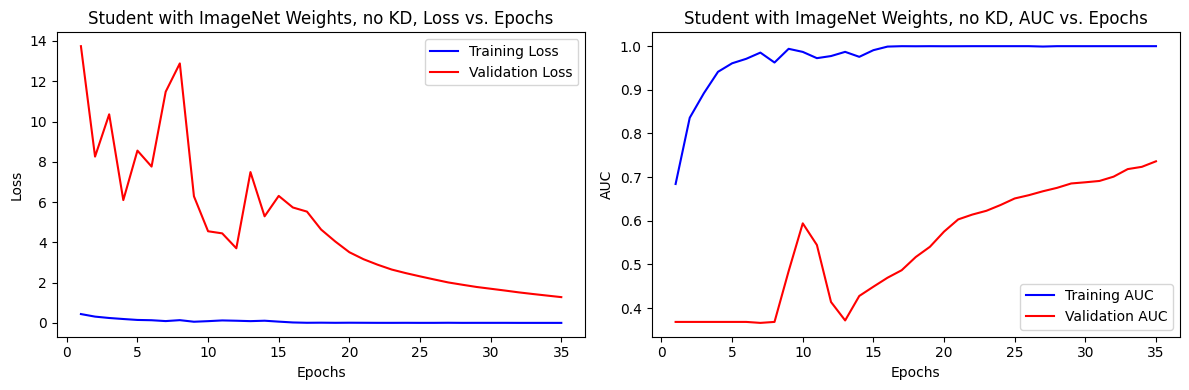

In [ ]:
# Extract data from training history
train_loss = history_initial.history['loss'] + history_finetuning.history['loss']
val_loss = history_initial.history['val_loss'] + history_finetuning.history['val_loss']
train_auc = history_initial.history['auc'] + history_finetuning.history['auc_1']
val_auc = history_initial.history['val_auc'] + history_finetuning.history['val_auc_1']

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Student with ImageNet Weights, no KD, Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Student with ImageNet Weights, no KD, AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


**Student (no KD) with no pre-set weights**

In [ ]:
#same as previous model except weights are not selected in the model object instantiation

base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[AUC(curve='PR')])

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')

history_initial = model.fit(
    train_images, train_labels_binary,
    epochs=10,
    validation_data=(test_images, test_labels_binary),
    batch_size=32
)

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[AUC(curve='PR')])

history_finetuning = model.fit(
    train_images, train_labels_binary,
    epochs=25,
    validation_data=(test_images, test_labels_binary),
    callbacks=[lr_schedule],
    batch_size=32
)

test_predictions = model.predict(test_images).flatten()
test_predictions_binary = (test_predictions > 0.5).astype(np.int32)
f1 = f1_score(test_labels_binary, test_predictions_binary)
print("F1 Score on Test Data:", f1)


Epoch 1/10
68/68 [==============================] - 44s 128ms/step - loss: 0.4623 - auc_1: 0.6666 - val_loss: 6.6869 - val_auc_1: 0.3685
Epoch 2/10
68/68 [==============================] - 5s 79ms/step - loss: 0.3179 - auc_1: 0.8400 - val_loss: 9.0406 - val_auc_1: 0.3685
Epoch 3/10
68/68 [==============================] - 6s 94ms/step - loss: 0.2237 - auc_1: 0.9214 - val_loss: 11.3040 - val_auc_1: 0.3685
Epoch 4/10
68/68 [==============================] - 5s 70ms/step - loss: 0.1799 - auc_1: 0.9481 - val_loss: 9.2980 - val_auc_1: 0.3685
Epoch 5/10
68/68 [==============================] - 5s 69ms/step - loss: 0.1947 - auc_1: 0.9327 - val_loss: 7.9503 - val_auc_1: 0.3685
Epoch 6/10
68/68 [==============================] - 5s 79ms/step - loss: 0.1048 - auc_1: 0.9813 - val_loss: 7.9096 - val_auc_1: 0.3685
Epoch 7/10
68/68 [==============================] - 5s 69ms/step - loss: 0.1044 - auc_1: 0.9795 - val_loss: 8.9234 - val_auc_1: 0.3663
Epoch 8/10
68/68 [==============================] - 

Epoch 1/25
68/68 [==============================] - 29s 117ms/step - loss: 0.1430 - auc_2: 0.9668 - val_loss: 5.0611 - val_auc_2: 0.5197 - lr: 0.0010
Epoch 2/25
68/68 [==============================] - 5s 69ms/step - loss: 0.0817 - auc_2: 0.9844 - val_loss: 10.3197 - val_auc_2: 0.3685 - lr: 0.0010
Epoch 3/25
68/68 [==============================] - 5s 78ms/step - loss: 0.0972 - auc_2: 0.9812 - val_loss: 10.5166 - val_auc_2: 0.3685 - lr: 0.0010
Epoch 4/25
68/68 [==============================] - ETA: 0s - loss: 0.0858 - auc_2: 0.9853
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
68/68 [==============================] - 5s 78ms/step - loss: 0.0858 - auc_2: 0.9853 - val_loss: 6.2529 - val_auc_2: 0.4113 - lr: 0.0010
Epoch 5/25
68/68 [==============================] - 5s 80ms/step - loss: 0.0337 - auc_2: 0.9973 - val_loss: 4.0446 - val_auc_2: 0.4925 - lr: 1.0000e-04
Epoch 6/25
68/68 [==============================] - 5s 70ms/step - loss: 0.0144 - auc_2: 0.9998

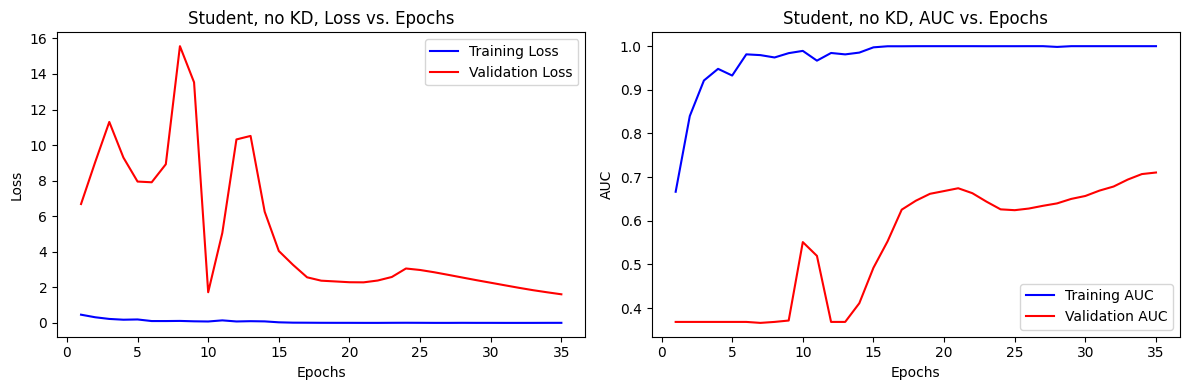

In [ ]:
# Extract data from training history
train_loss = history_initial.history['loss'] + history_finetuning.history['loss']
val_loss = history_initial.history['val_loss'] + history_finetuning.history['val_loss']
train_auc = history_initial.history['auc_1'] + history_finetuning.history['auc_2']
val_auc = history_initial.history['val_auc_1'] + history_finetuning.history['val_auc_2']

epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Student, no KD, Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Student, no KD, AUC vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


**Teacher**

In [4]:
#declare resnet model with imagenet weights and input shape, freeze top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# add layer for binary classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Binary classification, so use 1 unit and 'sigmoid' activation
])

# Compile the model with binary cross-entropy loss and AUC metric
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

# Train the model for 10 epochs
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

# Unfreeze some layers for fine-tuning
for layer in model.layers[0].layers[-30:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Lower the learning rate for fine-tuning
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

# Fine-tune the model for 25 epochs
history_fine_tuning = model.fit(train_images, train_labels, epochs=25, batch_size=32, validation_data=(test_images, test_labels))

# Extract logits for train and test datasets
train_logits = model.predict(train_images)
test_logits = model.predict(test_images)


94668760/94668760 [==============================] - 3s 0us/step


Epoch 1/10
68/68 [==============================] - 18s 95ms/step - loss: 8.8697 - auc: 0.5112 - val_loss: 3.2580 - val_auc: 0.6359
Epoch 2/10
68/68 [==============================] - 4s 53ms/step - loss: 2.7898 - auc: 0.6124 - val_loss: 5.0112 - val_auc: 0.6164
Epoch 3/10
68/68 [==============================] - 4s 52ms/step - loss: 2.6519 - auc: 0.6089 - val_loss: 3.6339 - val_auc: 0.6349
Epoch 4/10
68/68 [==============================] - 4s 53ms/step - loss: 2.3304 - auc: 0.6156 - val_loss: 2.5287 - val_auc: 0.6466
Epoch 5/10
68/68 [==============================] - 4s 53ms/step - loss: 2.2486 - auc: 0.6195 - val_loss: 4.7738 - val_auc: 0.5199
Epoch 6/10
68/68 [==============================] - 4s 52ms/step - loss: 2.4495 - auc: 0.6090 - val_loss: 2.0117 - val_auc: 0.6622
Epoch 7/10
68/68 [==============================] - 4s 52ms/step - loss: 2.0198 - auc: 0.6343 - val_loss: 2.6869 - val_auc: 0.6593
Epoch 8/10
68/68 [==============================] - 4s 52ms/step - loss: 2.4963 - 

Epoch 1/25
68/68 [==============================] - 12s 86ms/step - loss: 0.6337 - auc: 0.5438 - val_loss: 3.8957 - val_auc: 0.5000
Epoch 2/25
68/68 [==============================] - 4s 56ms/step - loss: 0.5765 - auc: 0.6436 - val_loss: 0.8169 - val_auc: 0.5678
Epoch 3/25
68/68 [==============================] - 4s 57ms/step - loss: 0.5627 - auc: 0.6785 - val_loss: 0.6617 - val_auc: 0.6320
Epoch 4/25
68/68 [==============================] - 4s 56ms/step - loss: 0.5578 - auc: 0.6791 - val_loss: 0.6615 - val_auc: 0.6706
Epoch 5/25
68/68 [==============================] - 4s 56ms/step - loss: 0.5505 - auc: 0.6959 - val_loss: 0.6076 - val_auc: 0.7021
Epoch 6/25
68/68 [==============================] - 4s 57ms/step - loss: 0.5336 - auc: 0.7345 - val_loss: 0.6045 - val_auc: 0.7093
Epoch 7/25
68/68 [==============================] - 4s 56ms/step - loss: 0.5348 - auc: 0.7254 - val_loss: 0.6048 - val_auc: 0.7138
Epoch 8/25
68/68 [==============================] - 4s 56ms/step - loss: 0.5272 - 

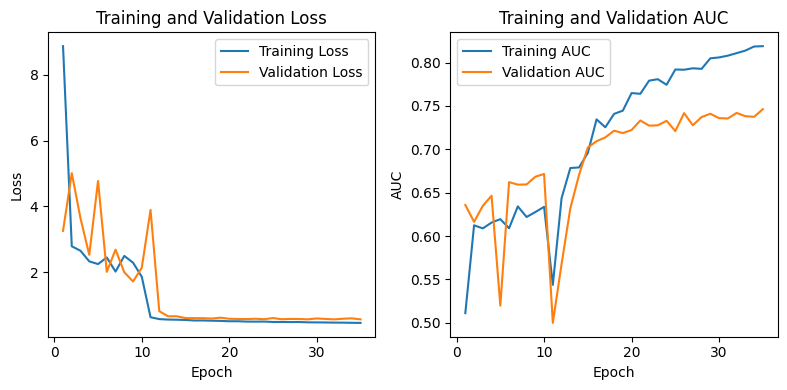

In [5]:
# Plot training and validation metrics
epochs = np.arange(1, 36)  # Number of epochs (10 initial + 25 fine-tuning)
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'] + history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'] + history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot AUC
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['auc'] + history_fine_tuning.history['auc'], label='Training AUC')
plt.plot(epochs, history.history['val_auc'] + history_fine_tuning.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Training and Validation AUC')

plt.tight_layout()
plt.show()

In [17]:
train_logits = np.load("/content/drive/MyDrive/ECE1512/train_logits.npy")
test_logits = np.load("/content/drive/MyDrive/ECE1512/test_logits.npy")

In [10]:
train_images = np.load("/content/drive/MyDrive/ECE1512/train_images.npy")
test_images = np.load("/content/drive/MyDrive/ECE1512/test_images.npy")
train_labels = np.load("/content/drive/MyDrive/ECE1512/train_labels.npy")
test_labels = np.load("/content/drive/MyDrive/ECE1512/test_labels.npy")

**Student with KD**

In [52]:
num_classes = 1  # Binary classification

# Load pre-trained ResNet50V2 model without top classification layers
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Global Average Pooling layer on top of ResNet50V2
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Load pre-trained MobileNetV2 model without top classification layers
mobilenet_base = MobileNetV2(weights=None, input_shape=(224, 224, 3), include_top=False)

# Global Average Pooling layer on top of MobileNetV2
mobilenet_output = GlobalAveragePooling2D()(mobilenet_base.output)

# Concatenate the outputs of ResNet50V2 and MobileNetV2
combined_output = tf.keras.layers.Concatenate()([resnet_output, mobilenet_output])

# Dense layers for binary classification on top of combined features
predictions = Dense(num_classes, activation='sigmoid')(combined_output)

# Create the final model
model = Model(inputs=[resnet_base.input, mobilenet_base.input], outputs=predictions)

# Define temperature for distillation
temperature = 5
alpha = 0.5  # You can adjust the alpha value as needed

# Define custom loss function for knowledge distillation using Kullback-Leibler divergence
def knowledge_distillation_loss(y_true, y_pred):
    y_true_softmax = tf.nn.softmax(y_true / temperature)
    y_pred_softmax = tf.nn.softmax(y_pred / temperature)
    return alpha * KLDivergence()(y_true_softmax, y_pred_softmax) + (1 - alpha) * BinaryCrossentropy()(y_true, y_pred)

# Initial training with higher learning rate
initial_learning_rate = 0.001
batch_size = 32
epochs_initial = 10

model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss=knowledge_distillation_loss, metrics=[AUC(curve='PR')])

history_initial = model.fit([train_images, train_images], train_labels, epochs=epochs_initial, batch_size=batch_size, validation_data=([test_images, test_images], test_labels))

# Fine-tuning with lower learning rate
fine_tuning_learning_rate = 0.0001
epochs_fine_tuning = 25

model.compile(optimizer=Adam(learning_rate=fine_tuning_learning_rate), loss=knowledge_distillation_loss, metrics=[AUC(curve='PR')])

history_fine_tuning = model.fit([train_images, train_images], train_labels, epochs=epochs_fine_tuning, batch_size=batch_size, validation_data=([test_images, test_images], test_labels))

# Evaluate the model
loss, auc_pr = model.evaluate([test_images, test_images], test_labels)
print("Test Loss:", loss)
print("AUC-PR:", auc_pr)


Epoch 1/10
68/68 [==============================] - 55s 159ms/step - loss: 0.2878 - auc_13: 0.4088 - val_loss: 1.3673 - val_auc_13: 0.3253
Epoch 2/10
68/68 [==============================] - 8s 115ms/step - loss: 0.2383 - auc_13: 0.6044 - val_loss: 0.3869 - val_auc_13: 0.4310
Epoch 3/10
68/68 [==============================] - 8s 114ms/step - loss: 0.2258 - auc_13: 0.6580 - val_loss: 10.6854 - val_auc_13: 0.3823
Epoch 4/10
68/68 [==============================] - 8s 115ms/step - loss: 0.1916 - auc_13: 0.7407 - val_loss: 121.3669 - val_auc_13: 0.3685
Epoch 5/10
68/68 [==============================] - 8s 115ms/step - loss: 0.1573 - auc_13: 0.8260 - val_loss: 0.5650 - val_auc_13: 0.6075
Epoch 6/10
68/68 [==============================] - 8s 115ms/step - loss: 0.1487 - auc_13: 0.8482 - val_loss: 0.7480 - val_auc_13: 0.4405
Epoch 7/10
68/68 [==============================] - 8s 115ms/step - loss: 0.1104 - auc_13: 0.9125 - val_loss: 0.4035 - val_auc_13: 0.5985
Epoch 8/10
68/68 [============

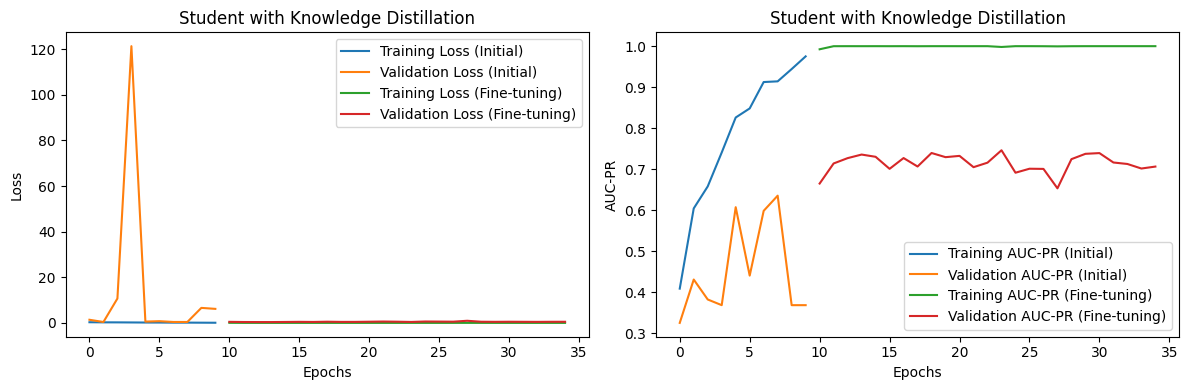

In [56]:
# Plotting the training and validation curves for initial training and fine-tuning
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_initial), history_initial.history['loss'], label='Training Loss (Initial)')
plt.plot(range(epochs_initial), history_initial.history['val_loss'], label='Validation Loss (Initial)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Student with Knowledge Distillation')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_initial), history_initial.history['auc_13'], label='Training AUC-PR (Initial)')
plt.plot(range(epochs_initial), history_initial.history['val_auc_13'], label='Validation AUC-PR (Initial)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['auc_14'], label='Training AUC-PR (Fine-tuning)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['val_auc_14'], label='Validation AUC-PR (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('AUC-PR')
plt.legend()
plt.title('Student with Knowledge Distillation')

plt.tight_layout()
plt.show()

In [57]:
#add data augmentation

num_classes = 1  # Binary classification

# Data augmentation configuration for training images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    rescale=1./255  # Normalize pixel values to [0, 1]
)

# Load pre-trained ResNet50V2 model without top classification layers
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Global Average Pooling layer on top of ResNet50V2
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Load pre-trained MobileNetV2 model without top classification layers
mobilenet_base = MobileNetV2(weights=None, input_shape=(224, 224, 3), include_top=False)

# Global Average Pooling layer on top of MobileNetV2
mobilenet_output = GlobalAveragePooling2D()(mobilenet_base.output)

# Concatenate the outputs of ResNet50V2 and MobileNetV2
combined_output = tf.keras.layers.Concatenate()([resnet_output, mobilenet_output])

# Dense layers for binary classification on top of combined features
predictions = Dense(num_classes, activation='sigmoid')(combined_output)

# Create the final model
model = Model(inputs=[resnet_base.input, mobilenet_base.input], outputs=predictions)

# Define temperature for distillation
temperature = 4
alpha = 0.5  # You can adjust the alpha value as needed

# Define custom loss function for knowledge distillation using Kullback-Leibler divergence
def knowledge_distillation_loss(y_true, y_pred):
    y_true_softmax = tf.nn.softmax(y_true / temperature)
    y_pred_softmax = tf.nn.softmax(y_pred / temperature)
    return alpha * KLDivergence()(y_true_softmax, y_pred_softmax) + (1 - alpha) * BinaryCrossentropy()(y_true, y_pred)

# Initial training with higher learning rate
initial_learning_rate = 0.001
batch_size = 32
epochs_initial = 10

model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss=knowledge_distillation_loss, metrics=[AUC(curve='PR')])

# Applying data augmentation during training
train_generator = datagen.flow([train_images, train_images], train_labels, batch_size=batch_size)

history_initial = model.fit(train_generator, epochs=epochs_initial, validation_data=([test_images, test_images], test_labels))

# Fine-tuning with lower learning rate
fine_tuning_learning_rate = 0.0001
epochs_fine_tuning = 25

model.compile(optimizer=Adam(learning_rate=fine_tuning_learning_rate), loss=knowledge_distillation_loss, metrics=[AUC(curve='PR')])

# Applying data augmentation during fine-tuning
train_generator = datagen.flow([train_images, train_images], train_labels, batch_size=batch_size)

history_fine_tuning = model.fit(train_generator, epochs=epochs_fine_tuning, validation_data=([test_images, test_images], test_labels))

# Evaluate the model
loss, auc_pr = model.evaluate([test_images, test_images], test_labels)
print("Test Loss:", loss)
print("AUC-PR:", auc_pr)

Epoch 1/10
68/68 [==============================] - 70s 392ms/step - loss: 0.2999 - auc_15: 0.3927 - val_loss: 947.0748 - val_auc_15: 0.3685
Epoch 2/10
68/68 [==============================] - 24s 349ms/step - loss: 0.2638 - auc_15: 0.5000 - val_loss: 19.9008 - val_auc_15: 0.3685
Epoch 3/10
68/68 [==============================] - 24s 352ms/step - loss: 0.2424 - auc_15: 0.5757 - val_loss: 414.0632 - val_auc_15: 0.3685
Epoch 4/10
68/68 [==============================] - 24s 352ms/step - loss: 0.2552 - auc_15: 0.5809 - val_loss: 1368.1771 - val_auc_15: 0.3685
Epoch 5/10
68/68 [==============================] - 24s 351ms/step - loss: 0.2361 - auc_15: 0.6439 - val_loss: 676.5281 - val_auc_15: 0.3685
Epoch 6/10
68/68 [==============================] - 24s 352ms/step - loss: 0.2005 - auc_15: 0.7393 - val_loss: 13414.5586 - val_auc_15: 0.3685
Epoch 7/10
68/68 [==============================] - 24s 354ms/step - loss: 0.1906 - auc_15: 0.7612 - val_loss: 6197.0498 - val_auc_15: 0.3685
Epoch 8/10

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

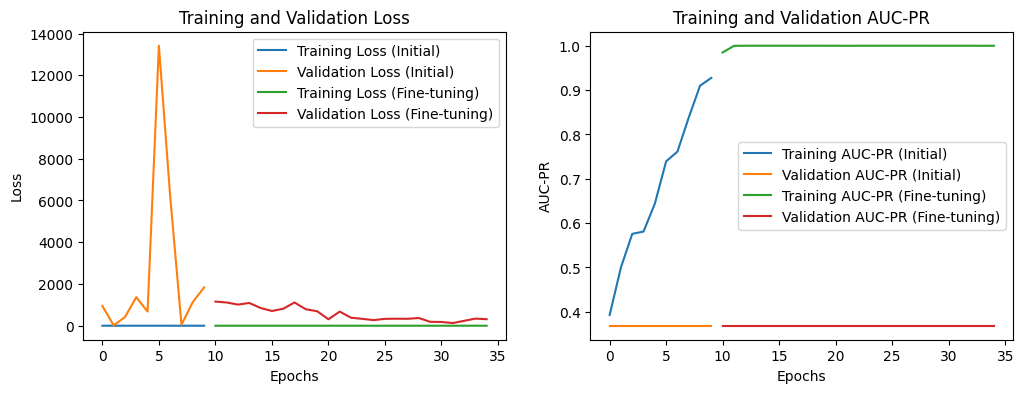

In [58]:
# Plotting the training and validation curves for initial training and fine-tuning
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs_initial), history_initial.history['loss'], label='Training Loss (Initial)')
plt.plot(range(epochs_initial), history_initial.history['val_loss'], label='Validation Loss (Initial)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['loss'], label='Training Loss (Fine-tuning)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_initial), history_initial.history['auc_15'], label='Training AUC-PR (Initial)')
plt.plot(range(epochs_initial), history_initial.history['val_auc_15'], label='Validation AUC-PR (Initial)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['auc_16'], label='Training AUC-PR (Fine-tuning)')
plt.plot(range(epochs_initial, epochs_initial + epochs_fine_tuning), history_fine_tuning.history['val_auc_16'], label='Validation AUC-PR (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('AUC-PR')
plt.legend()
plt.title('Training and Validation AUC-PR')

plt.tight_layout


In [59]:
num_classes = 1  # Binary classification

# Load pre-trained ResNet50V2 model without top classification layers
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Global Average Pooling layer on top of ResNet50V2
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Load pre-trained MobileNetV2 model without top classification layers
mobilenet_base = MobileNetV2(weights=None, input_shape=(224, 224, 3), include_top=False)

# Global Average Pooling layer on top of MobileNetV2
mobilenet_output = GlobalAveragePooling2D()(mobilenet_base.output)

# Concatenate the outputs of ResNet50V2 and MobileNetV2
combined_output = tf.keras.layers.Concatenate()([resnet_output, mobilenet_output])

# Dense layers for binary classification on top of combined features
predictions = Dense(num_classes, activation='sigmoid')(combined_output)

# Create the final model
model = Model(inputs=[resnet_base.input, mobilenet_base.input], outputs=predictions)

# Define a list of temperature values to experiment with
temperature_values = [1, 2, 4, 8, 16, 32, 64]

# Define alpha for knowledge distillation
alpha = 0.1  # You can adjust the alpha value as needed

# Function to train the model with a specific temperature value
def train_model_with_temperature(temperature):
    # Define custom loss function for knowledge distillation using Kullback-Leibler divergence
    def knowledge_distillation_loss(y_true, y_pred):
        y_true_softmax = tf.nn.softmax(y_true / temperature)
        y_pred_softmax = tf.nn.softmax(y_pred / temperature)
        return alpha * KLDivergence()(y_true_softmax, y_pred_softmax) + (1 - alpha) * BinaryCrossentropy()(y_true, y_pred)

    # Compile the model with the current temperature value
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=knowledge_distillation_loss, metrics=[AUC(curve='PR')])

    # Train the model
    history = model.fit([train_images, train_images], train_labels, epochs=25, batch_size=32,
                        validation_data=([test_images, test_images], test_labels), verbose=0)

    # Evaluate the model on the test data
    loss, auc_pr = model.evaluate([test_images, test_images], test_labels, verbose=0)
    print(f"Temperature: {temperature}, Test Loss: {loss}, AUC-PR: {auc_pr}")

    return history, loss, auc_pr

# Train the model with different temperature values and collect results
histories = []
test_losses = []
test_auc_prs = []

for temperature in temperature_values:
    history, test_loss, test_auc_pr = train_model_with_temperature(temperature)
    histories.append(history)
    test_losses.append(test_loss)
    test_auc_prs.append(test_auc_pr)


Temperature: 1, Test Loss: 0.7996193170547485, AUC-PR: 0.7595028877258301
Temperature: 2, Test Loss: 0.8796325325965881, AUC-PR: 0.789047360420227
Temperature: 4, Test Loss: 0.8845536708831787, AUC-PR: 0.8264573812484741
Temperature: 8, Test Loss: 0.8343126177787781, AUC-PR: 0.8544337749481201
Temperature: 16, Test Loss: 0.7617448568344116, AUC-PR: 0.8389843106269836
Temperature: 32, Test Loss: 0.8342940211296082, AUC-PR: 0.8342620134353638
Temperature: 64, Test Loss: 1.0287328958511353, AUC-PR: 0.8004746437072754


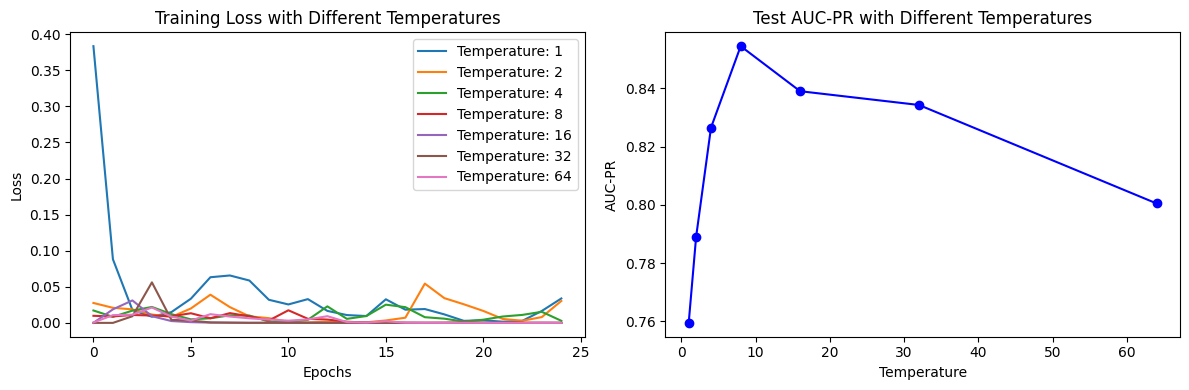

In [60]:
# Plotting the loss and validation AUC-PR for different temperature values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i, temperature in enumerate(temperature_values):
    plt.plot(histories[i].history['loss'], label=f'Temperature: {temperature}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss with Different Temperatures')

plt.subplot(1, 2, 2)
plt.plot(temperature_values, test_auc_prs, marker='o', linestyle='-', color='b')
plt.xlabel('Temperature')
plt.ylabel('AUC-PR')
plt.title('Test AUC-PR with Different Temperatures')

plt.tight_layout()
plt.show()

In [5]:
num_classes = 1  # Binary classification

# Load pre-trained ResNet50V2 model without top classification layers
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Global Average Pooling layer on top of ResNet50V2
resnet_output = GlobalAveragePooling2D()(resnet_base.output)

# Load pre-trained MobileNetV2 model without top classification layers
mobilenet_base = MobileNetV2(weights=None, input_shape=(224, 224, 3), include_top=False)

# Global Average Pooling layer on top of MobileNetV2
mobilenet_output = GlobalAveragePooling2D()(mobilenet_base.output)

# Concatenate the outputs of ResNet50V2 and MobileNetV2
combined_output = tf.keras.layers.Concatenate()([resnet_output, mobilenet_output])

# Dense layers for binary classification on top of combined features
predictions = Dense(num_classes, activation='sigmoid')(combined_output)

# Create the final model
model = Model(inputs=[resnet_base.input, mobilenet_base.input], outputs=predictions)

# Define a list of alpha values with increments of 0.15
alpha_values = np.arange(0.1, 1.0, 0.15)

# Define a fixed temperature value
temperature = 8

# Function to train the model with a specific alpha value
def train_model_with_alpha(alpha):
    # Define custom loss function for knowledge distillation using Kullback-Leibler divergence
    def knowledge_distillation_loss(y_true, y_pred):
        y_true_softmax = tf.nn.softmax(y_true / temperature)
        y_pred_softmax = tf.nn.softmax(y_pred / temperature)
        return alpha * KLDivergence()(y_true_softmax, y_pred_softmax) + (1 - alpha) * BinaryCrossentropy()(y_true, y_pred)

    # Compile the model with the current alpha value
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=knowledge_distillation_loss, metrics=[AUC(curve='PR')])

    # Train the model
    history = model.fit([train_images, train_images], train_labels, epochs=25, batch_size=32,
                        validation_data=([test_images, test_images], test_labels), verbose=0)

    # Evaluate the model on the test data
    loss, auc_pr = model.evaluate([test_images, test_images], test_labels, verbose=0)
    print(f"Alpha: {alpha}, Test Loss: {loss}, AUC-PR: {auc_pr}")

    return history, loss, auc_pr

# Train the model with different alpha values and collect results
histories = []
test_losses = []
test_auc_prs = []

for alpha in alpha_values:
    history, test_loss, test_auc_pr = train_model_with_alpha(alpha)
    histories.append(history)
    test_losses.append(test_loss)
    test_auc_prs.append(test_auc_pr)


Alpha: 0.1, Test Loss: 0.6973122954368591, AUC-PR: 0.838087260723114
Alpha: 0.25, Test Loss: 0.6356930732727051, AUC-PR: 0.8562310338020325
Alpha: 0.4, Test Loss: 0.527223527431488, AUC-PR: 0.8462920188903809
Alpha: 0.5499999999999999, Test Loss: 0.37078583240509033, AUC-PR: 0.8603386282920837
Alpha: 0.7, Test Loss: 0.23226499557495117, AUC-PR: 0.8524681329727173
Alpha: 0.85, Test Loss: 0.14371316134929657, AUC-PR: 0.8371704816818237


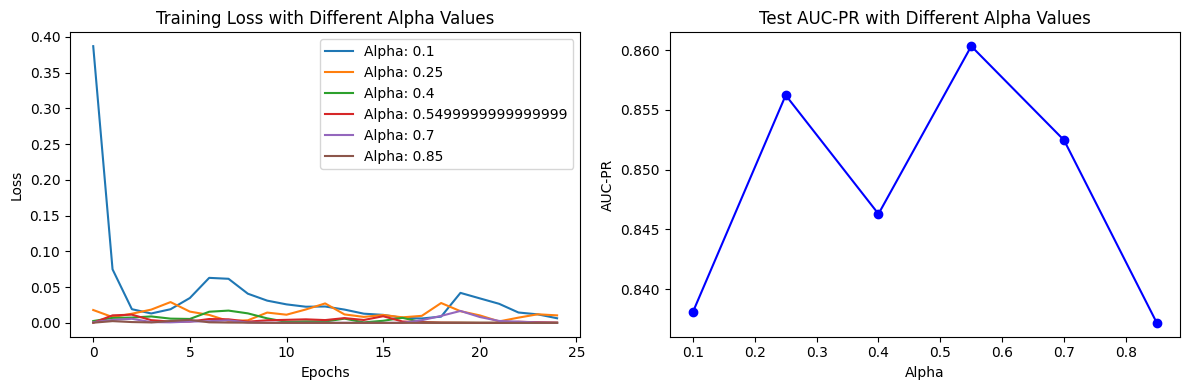

In [19]:
# Plotting the loss and validation AUC-PR for different alpha values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(histories[i].history['loss'], label=f'Alpha: {alpha}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss with Different Alpha Values')

plt.subplot(1, 2, 2)
plt.plot(alpha_values, test_auc_prs, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('AUC-PR')
plt.title('Test AUC-PR with Different Alpha Values')

plt.tight_layout()
plt.show()

**Determine FLOPs**

In [23]:
# I used the following code from Christos Kyrkou to determine the flops

def net_flops(model, table=False):
    if (table == True):
        print('%25s | %16s | %16s | %16s | %16s | %6s | %6s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS'))
        print('-' * 170)

    t_flops = 0
    t_macc = 0

    for l in model.layers:

        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if ('InputLayer' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if ('Reshape' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if ('Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('Average' in str(l) and 'pool' not in str(l)):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if ('BatchNormalization' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('Activation' in str(l) or 'activation' in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if ('pool' in str(l) and ('Global' not in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if ('Flatten' in str(l)):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if ('Dense' in str(l)):
            print(l.input)
            i_shape = l.input.shape[1:4].as_list()[0]
            if (i_shape == None):
                i_shape = out_vec

            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if ('Padding' in str(l)):
            flops = 0

        if (('Global' in str(l))):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if ('Conv2D ' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l)):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if (filters == None):
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc

        t_flops += flops

        if (table == True):
            print('%25s | %16s | %16s | %16s | %16s | %6s | %5.4f' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), flops))
    t_flops = t_flops / factor

    print('\nTotal FLOPS (x 10^6): %10.8f\n' % (t_flops))
    print('\nTotal MACCs: %10.8f\n' % (t_macc))

    return

In [26]:
#teacher model
print("teacher model")
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
net_flops(resnet_base)

print("student model")
#student model
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
net_flops(base_model)


teacher model

Total FLOPS (x 10^6): 7953.49497600


Total MACCs: 3973403328.00000000

student model

Total FLOPS (x 10^6): 599.49976800


Total MACCs: 299641692.00000000

